In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import patsy

In [2]:
crimes = pd.read_csv('~/data/chicago_crime_data.csv')

In [3]:
crimes.index = crimes['ID'] # make the index the actual case number
# remove columns that are unnecessary for the analysis and would probably just slow our code down
crimes = crimes.drop(['Beat', 'FBI Code','Updated On', 'Case Number', 'Block', 'IUCR', 'ID', 'Description', 'Ward', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude'], axis=1)




In [4]:
crime_types = crimes['Primary Type'].unique().tolist()

### Begin cleaning data

1. Remove NaN values
2. standardize the crime type to get rid of the uppercase, standardize the non-criminal type
3. standardize the location description

There are actually no Nan values to remove! Government data is reliable I guess. The only NaN values are location, but we still know the district, so as long as we don't end up needing location later on, this is fine

In [5]:
to_drop = crimes[crimes.isnull().any(axis=1)]
to_drop;

In [6]:
def standardize_primary_type(string):
    # compile all non-criminal offenses into on label
    if string == 'NON-CRIMINAL (SUBJECT SPECIFIED)' or string == 'NON - CRIMINAL' or string == 'NON-CRIMINAL':
        return 'non-criminal'
    if string == 'OTHER OFFENSE':
        return 'other'
    # rename crim sexual assault to just sexual assault to make it easier to read
    if string == 'CRIM SEXUAL ASSAULT':
        return 'sexual assault'
    else:
        # everything else, make sure to lowercase it so we don't have to use caps lock lol
        return string.lower()
        

In [7]:
def standardize_location(string):
    if type(string) == str:
        string = string.lower()
        if 'airport' in string:
            return 'airport'
    return string

In [8]:
crimes['Primary Type'] = crimes['Primary Type'].apply(standardize_primary_type) # clean data 
crimes['location'] = crimes['Location Description'].apply(standardize_location)

In [9]:
# be careful if you run this one, only run it once it won't work the second time 
crimes = crimes.drop(['Location Description','Community Area'],axis=1)

In [10]:
crimes = crimes.rename(columns = {'Location': 'Coordinates'})

In [11]:
crimes['Primary Type'].value_counts().nlargest(3)

theft              1431614
battery            1241949
criminal damage     776795
Name: Primary Type, dtype: int64

In [12]:
districts = crimes['District'].unique().tolist()
districts.remove(21)

In [13]:
district_cache = {}
for district in districts:
    district_cache[district] = crimes[ crimes['District'] == district ]

In [17]:
crimes = crimes.rename(columns={'Primary Type': 'Type'})

In [18]:
def arrest_to_int(string):
    if string == True:
        return 1
    elif string == False:
        return 0
crimes['ArrestInts'] = crimes['Arrest'].apply(arrest_to_int)

<BarContainer object of 33 artists>

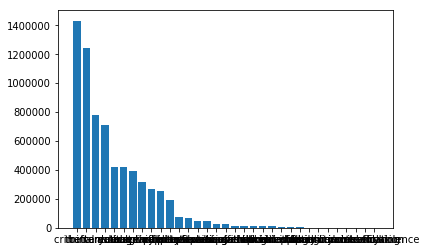

In [ ]:

plt.bar(crimes.Type.value_counts().index, crimes.Type.value_counts())
# rotate labels

In [ ]:
crimes.Type.value_counts()

theft                                1431614
battery                              1241949
criminal damage                       776795
narcotics                             713871
assault                               422506
other                                 422241
burglary                              390366
motor vehicle theft                   316367
deceptive practice                    266860
robbery                               257631
criminal trespass                     194802
weapons violation                      71828
prostitution                           68484
public peace violation                 48068
offense involving children             45866
sexual assault                         27522
sex offense                            25322
interference with public officer       15397
gambling                               14431
liquor law violation                   14096
arson                                  11227
homicide                                9529
kidnapping

In [ ]:
ind = (crimes.Type=='battery').values | (crimes.Type=='theft').values |  (crimes.Type=='narcotics').values |  (crimes.Type=='criminal damage').values 


In [ ]:
crimes['District'] = crimes['District'].astype(str)

In [ ]:
#binomial_model = smf.glm(formula='ArrestInts ~ Type + District', data=crimes.loc[ind,:] , family=sm.families.Binomial())
binomial_model = smf.glm(formula='ArrestInts ~ Type + District', data=crimes , family=sm.families.Binomial())
binomial_results = binomial_model.fit()
binomial_results.summary()